Figuring out how to use PAM

In [212]:
import os
from copy import deepcopy

import acbm

import numpy as np
import pandas as pd
import geopandas as gpd
from pam.activity import Activity, Leg, Plan
from pam.location import Location
from pam.planner.choice_location import DiscretionaryTripOD, DiscretionaryTrips
from pam.planner.od import ODFactory, ODMatrix
from pam.planner.utils_planner import get_trip_chains_either_anchor
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from prettytable import PrettyTable
from shapely.geometry import Point
from libpysal.weights import Queen


from acbm.preprocessing import nts_filter_by_year, add_location
from acbm.assigning.primary_select import select_facility

pd.set_option('display.max_columns', None)


# Load in the data

In [213]:
activity_chains = pd.read_parquet(
    acbm.root_path / "data/interim/matching/spc_with_nts_trips.parquet"
)
activity_chains = activity_chains[activity_chains["TravDay"] == 3]  # Wednesday


## Add OA21CD to the data

We will use it to select home locations using select_facility()

In [214]:
where_clause = "MSOA21NM LIKE '%Leeds%'"

boundaries = gpd.read_file(
    acbm.root_path / "data/external/boundaries/oa_england.geojson", where=where_clause
)

# convert boundaries to 4326
boundaries = boundaries.to_crs(epsg=4326)


# --- Assign activity home locations to boundaries zoning system

# Convert location column in activity_chains to spatial column
centroid_layer = pd.read_csv(
    acbm.root_path / "data/external/centroids/Output_Areas_Dec_2011_PWC_2022.csv"
)
activity_chains = add_location(
    activity_chains, "EPSG:27700", "EPSG:4326", centroid_layer, "OA11CD", "OA11CD"
)

# Convert the DataFrame into a GeoDataFrame, and assign a coordinate reference system (CRS)
activity_chains = gpd.GeoDataFrame(activity_chains, geometry="location")
activity_chains.crs = "EPSG:4326"  # I assume this is the crs


# remove index_right column from activity_chains if it exists
if "index_right" in activity_chains.columns:
    activity_chains = activity_chains.drop(columns="index_right")


# Spatial join to identify which polygons each point is in
activity_chains = gpd.sjoin(
    activity_chains, boundaries[["OA21CD", "geometry"]], how="left", predicate="within"
)
activity_chains = activity_chains.drop("index_right", axis=1)

2024-08-09 11:34:23,339 - DEBUG - GDAL_DATA found in environment.
2024-08-09 11:34:23,340 - DEBUG - PROJ_DATA found in environment.
2024-08-09 11:34:28,234 - DEBUG - GDAL_DATA found in environment.
2024-08-09 11:34:28,235 - DEBUG - PROJ_DATA found in environment.
2024-08-09 11:34:28,235 - DEBUG - Got coordinate system
2024-08-09 11:34:28,235 - DEBUG - Got coordinate system
2024-08-09 11:34:28,237 - DEBUG - Matched. confidence=100, c_code=b'27700', c_name=b'EPSG'
2024-08-09 11:34:28,238 - DEBUG - OLC_FASTSETNEXTBYINDEX: 0
2024-08-09 11:34:28,238 - DEBUG - OLC_FASTFEATURECOUNT: 0
2024-08-09 11:34:28,239 - DEBUG - Next index: 0
2024-08-09 11:34:28,240 - DEBUG - Next index: 1
2024-08-09 11:34:29,423 - DEBUG - Next index: 2
2024-08-09 11:34:29,423 - DEBUG - Next index: 3
2024-08-09 11:34:29,424 - DEBUG - Next index: 4
2024-08-09 11:34:29,425 - DEBUG - Next index: 5
2024-08-09 11:34:29,426 - DEBUG - Next index: 6
2024-08-09 11:34:29,427 - DEBUG - Next index: 7
2024-08-09 11:34:29,427 - DEBUG

In [215]:
# remove location column
activity_chains = activity_chains.drop(columns="location")

## Primary locations

In [216]:
activity_chains_edu = pd.read_pickle(
    acbm.root_path / "data/interim/assigning/activity_chains_education.pkl"
)

activity_chains_work = pd.read_pickle(
    acbm.root_path / "data/interim/assigning/activity_chains_work.pkl"
)


In [217]:
# get all activity chains where dact is home
activity_chains_home = activity_chains[activity_chains["dact"] == "home"]
# get all activity chains where dact is not work or education
activity_chains_other = activity_chains[
    ~activity_chains["dact"].isin(["work", "education", "home"])
]


In [218]:
(activity_chains.shape[0], 
 activity_chains_edu.shape[0], 
 activity_chains_work.shape[0], 
 activity_chains_home.shape[0], 
 activity_chains_other.shape[0])

(15811, 411, 1806, 6849, 6745)

In [219]:
activity_chains["dact"].value_counts()

dact
home         6849
other        2621
work         1806
escort       1762
shop         1281
visit         896
education     411
medical       185
Name: count, dtype: int64

# Add home locations


In [220]:
# osm data
osm_data_gdf = gpd.read_parquet(
    acbm.root_path / "data/external/boundaries/west-yorkshire_epsg_4326.parquet"
)

# get rows in osm_data_gdf where activities includes home

osm_data_gdf = osm_data_gdf[osm_data_gdf["activities"].str.contains("home")]
osm_data_gdf

# spatial join to identify which zone each point in osm_data is in
osm_data_gdf = gpd.sjoin(
    osm_data_gdf, boundaries[["OA21CD", "geometry"]], how="inner", predicate="within"
)

osm_data_gdf.head(10)

,id,activities,geometry,units,levels,area,floor_area,distance_to_nearest_transit,distance_to_nearest_shop,distance_to_nearest_medical,index_right,OA21CD
1,20621535,home,POINT (-1.56566 53.81375),1.0,2.0,0,0.0,198.493258,108.072976,255.853754,851,E00057657
2,21591858,home,POINT (-1.63279 53.87138),1.0,2.0,0,0.0,969.484065,509.809989,2318.285507,557,E00057349
5,27411630,home,POINT (-1.72353 53.90655),1.0,2.0,0,0.0,216.265895,986.041911,1716.667311,1524,E00058367
7,27470976,home,POINT (-1.56251 53.90203),1.0,2.0,0,0.0,873.984192,1799.502624,3250.842461,1478,E00058319
117,243857658,home,POINT (-1.58420 53.82091),1.0,2.0,0,0.0,254.519273,207.974705,391.618763,834,E00057637
215,263905389,home,POINT (-1.58480 53.83411),1.0,2.0,0,0.0,18.165010,538.231938,947.117436,2070,E00058957
233,266347353,home,POINT (-1.59132 53.86960),1.0,2.0,0,0.0,239.833745,330.022370,1799.256632,2475,E00170889
436,297118275,home,POINT (-1.65174 53.79927),1.0,2.0,0,0.0,78.022954,40.506960,23.413135,1632,E00058477
549,304609832,home,POINT (-1.62587 53.80985),1.0,2.0,0,0.0,46.651413,103.570196,161.971263,144,E00056906
623,317087655,home,POINT (-1.53952 53.79314),1.0,2.0,0,0.0,198.799706,55.563040,250.884104,2482,E00187029


## Calculate a home location only once per household

In [221]:
# Keep one row per household and select only household and OA21CD columns
activity_chains_home_hh = activity_chains_home.drop_duplicates(subset=["household"])
activity_chains_home_hh = activity_chains_home_hh[["household", "dact", "OA21CD"]]

In [222]:
activity_chains_home_hh

,household,dact,OA21CD
1,89,home,E00059031
11,139,home,E00059045
17,197,home,E00059023
21,283,home,E00059012
38,342,home,E00059033
...,...,...,...
15790,334049,home,E00187098
15792,334172,home,E00057789
15794,334223,home,E00170040
15799,334249,home,E00170267


## Get the home location

In [223]:
zone_neighbors = Queen.from_dataframe(boundaries, ids="OA21CD").neighbors


In [224]:
# apply the function to a row in activity_chains_ex
activity_chains_home_hh[["activity_id", "activity_geom"]] = activity_chains_home_hh.apply(
    lambda row: select_facility(
        row=row,
        facilities_gdf=osm_data_gdf,
        row_destination_zone_col="OA21CD",
        row_activity_type_col="dact",
        gdf_facility_zone_col="OA21CD",
        gdf_facility_type_col="activities",
        gdf_sample_col="floor_area",
        #neighboring_zones=zone_neighbors,
    ),
    axis=1,
)

2024-08-09 11:34:41,893 - assigning_primary_locations - INFO - Activity 1: Found 182 matching facilities in zone E00059031
2024-08-09 11:34:41,893 - INFO - Activity 1: Found 182 matching facilities in zone E00059031
2024-08-09 11:34:41,898 - assigning_primary_locations - INFO - Activity 1: Sampled facility based on floor area)
2024-08-09 11:34:41,898 - INFO - Activity 1: Sampled facility based on floor area)
2024-08-09 11:34:41,916 - assigning_primary_locations - INFO - Activity 11: Found 124 matching facilities in zone E00059045
2024-08-09 11:34:41,916 - INFO - Activity 11: Found 124 matching facilities in zone E00059045
2024-08-09 11:34:41,919 - assigning_primary_locations - INFO - Activity 11: Sampled facility based on floor area)
2024-08-09 11:34:41,919 - INFO - Activity 11: Sampled facility based on floor area)
2024-08-09 11:34:41,935 - assigning_primary_locations - INFO - Activity 17: Found 124 matching facilities in zone E00059023
2024-08-09 11:34:41,935 - INFO - Activity 17: Fo

In [225]:
activity_chains_home_hh.head(5)

,household,dact,OA21CD,activity_id,activity_geom
1,89,home,E00059031,1736848640,POINT (-1.395366169480434 53.9330853385698)
11,139,home,E00059045,1743398928,POINT (-1.396665407647222 53.92965513953519)
17,197,home,E00059023,1730050326,POINT (-1.391874214173042 53.93926336697978)
21,283,home,E00059012,1786588186,POINT (-1.386720955229352 53.94121743103629)
38,342,home,E00059033,1685619018,POINT (-1.406478878358912 53.93337464042498)


## Merge home locations back onto activity_chains_home

In [227]:
# join activity_chains_home_hh onto activity_chains_home based on household column
activity_chains_home = activity_chains_home.merge(
    activity_chains_home_hh[["household", "activity_id", "activity_geom"]],
    on="household",
    how="left",
)

activity_chains_home.head(5)


,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,OA21CD,activity_id,activity_geom
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,2.0,0.633716,1.115053,E00059031,1736848640,POINT (-1.395366169480434 53.9330853385698)
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,2.0,0.639694,1.125570,E00059031,1736848640,POINT (-1.395366169480434 53.9330853385698)
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2.0,1230.0,1260.0,13.0,13.0,30.0,30.0,2.0,2.0,0.568328,1.000000,E00059031,1736848640,POINT (-1.395366169480434 53.9330853385698)
3,200,89,2904867,E02002330,E00059031,"[199, 200, 201]",None,64.0,2,12675.225586,11.079742,E02002330_0090,1.0,NaN,6.0,True,2.0,2,2,38,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004706,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,1.0,3.0,2.0,2.0,1.0,5.0,car,escort,home,5.0,930.0,950.0,1.0,1.0,20.0,20.0,2.0,2.0,0.646775,1.138030,E00059031,1736848640,POINT (-1.395366169480434 53.9330853385698)
4,201,89,2903217,E02002330,E00059031,"[199, 200, 201]",None,NaN,0,NaN,NaN,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,7,1,2.0,34166.520508,2,0,2,1,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",2,2021004708,education_school,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,3.0,3.0,2.0,2.0,1.0,7.0,car,medical,home,6.0,930.0,950.0,1.0,1.0,20.0,20.0,2.0,2.0,0.646775,1.138030,E00059031,1736848640,POINT (-1.395366169480434 53.9330853385698)


# Combine all dataframes

In [244]:
# merge the three dataframes
activity_chains_all = pd.concat([activity_chains_edu, 
                                 activity_chains_work, 
                                 activity_chains_home,
                                 activity_chains_other])
# sort by houshold_id, individual_id, and sequence
activity_chains_all = activity_chains_all.sort_values(by=["household", "id", "seq"])
activity_chains_all.head(10)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,location,OA21CD,activity_id,activity_geom
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,2.0,walk,home,other,8.0,600.0,645.0,6.0,6.0,45.0,45.0,2.0,2.0,0.633716,1.115053,None,E00059031,NaN,NaN
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,2.0,0.633716,1.115053,None,E00059031,1736848640,POINT (-1.395366169480434 53.9330853385698)
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,home,shop,4.0,720.0,730.0,1.0,1.0,10.0,10.0,2.0,2.0,0.639694,1.125570,None,E00059031,NaN,NaN
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,2.0,0.639694,1.125570,None,E00059031,1736848640,POINT (-1.395366169480434 53.9330853385698)
10,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,5.0,2.0,1.0,5.0,car,home,work,2.0,810.0,830.0,13.0,13.0,20.0,20.0,2.0,E00058564,0.568328,1.000000,None,NaN,1955094120,POINT (-1.49656225379334 53.78439183373149)
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,6.0,2.0,1.0,5.0,car,work,home,2.0,1230.0,1260.0,13.0,13.0,30.0,30.0,2.0,2.0,0.56832

In [245]:
# Step 1: Create dictionaries to map each id to their activity_geom and activity_id for each activity type
activity_types = ["home", "education", "work"]
activity_geom_dict = {}
activity_id_dict = {}

for activity in activity_types:
    filtered_df = activity_chains_all[
        (activity_chains_all["dact"] == activity) & (activity_chains_all["activity_geom"].notnull())
    ]
    activity_geom_dict[activity] = filtered_df.set_index("id")["activity_geom"].to_dict()
    activity_id_dict[activity] = filtered_df.set_index("id")["activity_id"].to_dict()

# Step 2: Populate the origin_geom and origin_id columns based on the oact value
def get_origin_geom(row):
    if row["oact"] in activity_geom_dict and row["id"] in activity_geom_dict[row["oact"]]:
        return activity_geom_dict[row["oact"]][row["id"]]
    return None

def get_origin_id(row):
    if row["oact"] in activity_id_dict and row["id"] in activity_id_dict[row["oact"]]:
        return activity_id_dict[row["oact"]][row["id"]]
    return None

activity_chains_all = activity_chains_all.copy()
activity_chains_all["origin_geom"] = activity_chains_all.apply(get_origin_geom, axis=1)
activity_chains_all["origin_id"] = activity_chains_all.apply(get_origin_id, axis=1)

,id,household,pid_hs,msoa11cd,oa11cd,members,sic1d2007,sic2d2007,pwkstat,salary_yearly,salary_hourly,hid,accommodation_type,communal_type,num_rooms,central_heat,tenure,num_cars,sex,age_years,ethnicity,nssec8,salary_yearly_hh,salary_yearly_hh_cat,is_adult,num_adults,is_child,num_children,is_pension_age,num_pension_age,pwkstat_FT_hh,pwkstat_PT_hh,pwkstat_NTS_match,OA11CD,RUC11,RUC11CD,Settlement2011EW_B03ID_spc,Settlement2011EW_B04ID_spc,Settlement2011EW_B03ID_spc_CD,Settlement2011EW_B04ID_spc_CD,tenure_spc_for_matching,nts_hh_id,age_group,nts_ind_id,education_type,TripID,DayID,IndividualID,HouseholdID,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,MainMode_B03ID,mode,oact,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone,W5,W5xHH,location,OA21CD,activity_id,activity_geom,origin_geom,origin_id
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,1.0,2.0,1.0,2.0,walk,home,other,8.0,600.0,645.0,6.0,6.0,45.0,45.0,2.0,2.0,0.633716,1.115053,None,E00059031,NaN,NaN,POINT (-1.39537 53.93309),1736848640
0,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,2.0,2.0,1.0,2.0,walk,other,home,8.0,645.0,690.0,6.0,6.0,45.0,45.0,2.0,2.0,0.633716,1.115053,None,E00059031,1736848640,POINT (-1.395366169480434 53.9330853385698),None,None
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,3.0,2.0,1.0,5.0,car,home,shop,4.0,720.0,730.0,1.0,1.0,10.0,10.0,2.0,2.0,0.639694,1.125570,None,E00059031,NaN,NaN,POINT (-1.39537 53.93309),1736848640
1,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,4.0,2.0,1.0,5.0,car,shop,home,4.0,765.0,775.0,1.0,1.0,10.0,10.0,2.0,2.0,0.639694,1.125570,None,E00059031,1736848640,POINT (-1.395366169480434 53.9330853385698),None,None
10,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.021040e+09,2.021031e+09,2.021005e+09,2.021002e+09,2.021000e+09,2.0,3.0,5.0,2.0,1.0,5.0,car,home,work,2.0,810.0,830.0,13.0,13.0,20.0,20.0,2.0,E00058564,0.568328,1.000000,None,NaN,1955094120,POINT (-1.49656225379334 53.78439183373149),POINT (-1.39537 53.93309),1736848640
2,199,89,2906098,E02002330,E00059031,"[199, 200, 201]",C,26.0,1,21491.294922,10.332354,E02002330_0090,1.0,NaN,6.0,True,2.0,2,1,39,1,2.0,34166.520508,2,1,2,0,1,0,0,1,1,5,E00059031,Urban city and town,C1,Urban,Urban City and Town,1,2,1.0,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",6,2021004707,education_university,2.0

In [246]:
activity_chains_all = activity_chains_all[["id", "household", "nts_ind_id", "nts_hh_id", "age_years", 
                                           "oact", "dact", "TripTotalTime", "TripDisIncSW", "seq", "mode", "tst", "tet", 
                                           "origin_id", "origin_geom", "activity_id", "activity_geom"]]
activity_chains_all.head(10)

,id,household,nts_ind_id,nts_hh_id,age_years,oact,dact,TripTotalTime,TripDisIncSW,seq,mode,tst,tet,origin_id,origin_geom,activity_id,activity_geom
0,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,other,45.0,6.0,1.0,walk,600.0,645.0,1736848640,POINT (-1.39537 53.93309),NaN,NaN
0,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,other,home,45.0,6.0,2.0,walk,645.0,690.0,None,None,1736848640,POINT (-1.395366169480434 53.9330853385698)
2,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,shop,10.0,1.0,3.0,car,720.0,730.0,1736848640,POINT (-1.39537 53.93309),NaN,NaN
1,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,shop,home,10.0,1.0,4.0,car,765.0,775.0,None,None,1736848640,POINT (-1.395366169480434 53.9330853385698)
10,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,home,work,20.0,13.0,5.0,car,810.0,830.0,1736848640,POINT (-1.39537 53.93309),1955094120,POINT (-1.49656225379334 53.78439183373149)
2,199,89,2021004707,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",39,work,home,30.0,13.0,6.0,car,1230.0,1260.0,1955094120,POINT (-1.49656 53.78439),1736848640,POINT (-1.395366169480434 53.9330853385698)
6,200,89,2021004706,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",38,home,escort,75.0,1.0,1.0,car,765.0,840.0,1736848640,POINT (-1.39537 53.93309),NaN,NaN
3,200,89,2021004706,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",38,escort,home,20.0,1.0,2.0,car,930.0,950.0,None,None,1736848640,POINT (-1.395366169480434 53.9330853385698)
0,201,89,2021004708,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",7,home,education,5.0,1.0,1.0,car,520.0,525.0,1736848640,POINT (-1.39537 53.93309),160360912,POINT (-1.390539537152311 53.93323059983641)
4,201,89,2021004708,"[2019004119.0, 2019004122.0, 2019002766.0, 201...",7,medical,home,20.0,1.0,2.0,car,930.0,950.0,None,None,1736848640,POINT (-1.395366169480434 53.9330853385698)


# Prepare data fro PAM 

## Individuals

## Households

## Trips 

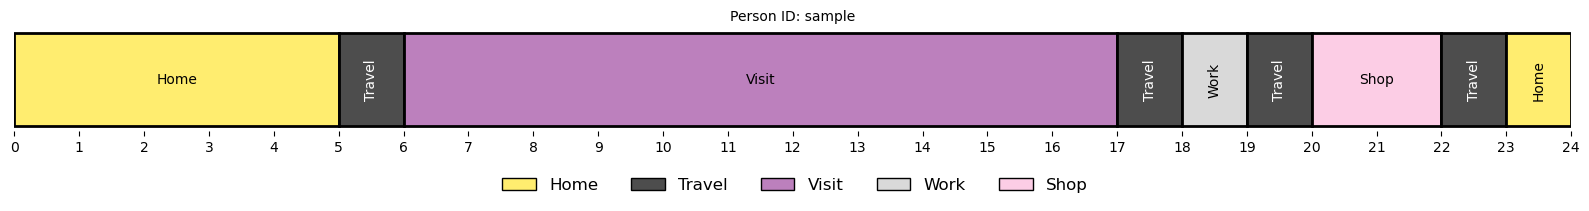

In [6]:
plan = Plan(home_area="h", home_location=Location(loc=Point(0, 0), area="h"))
plan.add(
    Activity(
        seq=1, act="home", area="h", loc=Point(0, 0), start_time=mtdt(0), end_time=mtdt(5 * 60)
    )
)
plan.add(
    Leg(
        seq=1,
        mode="car",
        start_area="h",
        end_area="w",
        start_loc=Point(0, 0),
        end_loc=Point(1, 2),
        start_time=mtdt(5 * 60),
        end_time=mtdt(6 * 60),
    )
)
plan.add(
    Activity(
        seq=2,
        act="visit",
        area="w",
        loc=Point(1, 2),
        start_time=mtdt(6 * 60),
        end_time=mtdt(17 * 60),
    )
)
plan.add(
    Leg(
        seq=2,
        mode="car",
        start_area="w",
        end_area="w",
        start_loc=Point(1, 2),
        end_loc=Point(0, 0),
        start_time=mtdt(17 * 60),
        end_time=mtdt(18 * 60),
    )
)
plan.add(
    Activity(
        seq=3,
        act="work",
        area="w",
        loc=Point(0, 0),
        start_time=mtdt(18 * 60),
        end_time=mtdt(19 * 60),
    )
)
plan.add(
    Leg(
        seq=3,
        mode="car",
        start_area="w",
        end_area="na",
        start_loc=Point(0, 0),
        end_loc=Point(1, 2),
        start_time=mtdt(19 * 60),
        end_time=mtdt(20 * 60),
    )
)
plan.add(
    Activity(
        seq=4,
        act="shop",
        area="na",
        loc=Point(2, 2),
        start_time=mtdt(20 * 60),
        end_time=mtdt(22 * 60),
    )
)
plan.add(
    Leg(
        seq=4,
        mode="car",
        start_area="na",
        end_area="h",
        start_loc=Point(2, 2),
        end_loc=Point(0, 0),
        start_time=mtdt(22 * 60),
        end_time=mtdt(23 * 60),
    )
)
plan.add(
    Activity(
        seq=5, act="home", area="h", loc=Point(0, 0), start_time=mtdt(23 * 60), end_time=END_OF_DAY
    )
)
plan.plot()

<bound method Plan.trips of <pam.activity.Plan object at 0x7233cc17d250>>


In [7]:
zone_labels = ("h", "b", "w")
od = ODFactory.from_matrices(
    [
        ODMatrix(
            "time",
            "car",
            zone_labels,
            zone_labels,
            np.array([[20, 30, 40], [30, 10, 30], [40, 30, 20]]),
        ),
        ODMatrix(
            "time",
            "bus",
            zone_labels,
            zone_labels,
            np.array([[30, 40, 45], [40, 10, 40], [45, 40, 30]]),
        ),
        ODMatrix(
            "distance", "car", zone_labels, zone_labels, np.array([[5, 6, 8], [6, 2, 6], [8, 6, 5]])
        ),
        ODMatrix(
            "distance", "bus", zone_labels, zone_labels, np.array([[5, 7, 9], [7, 2, 7], [9, 7, 5]])
        ),
        ODMatrix(
            "od_probs",
            "car",
            zone_labels,
            zone_labels,
            np.array([[500, 333, 250], [333, 1000, 333], [250, 333, 500]]),
        ),
        ODMatrix(
            "od_probs",
            "bus",
            zone_labels,
            zone_labels,
            np.array([[333, 250, 222], [250, 1000, 250], [222, 250, 333]]),
        ),
    ]
)
od

Origin-destination dataset 
--------------------------------------------------
Labels(vars=['time', 'distance', 'od_probs'], origin_zones=('h', 'b', 'w'), destination_zones=('h', 'b', 'w'), mode=['car', 'bus'])
--------------------------------------------------
time - car:
[[20. 30. 40.]
 [30. 10. 30.]
 [40. 30. 20.]]
--------------------------------------------------
time - bus:
[[30. 40. 45.]
 [40. 10. 40.]
 [45. 40. 30.]]
--------------------------------------------------
distance - car:
[[5. 6. 8.]
 [6. 2. 6.]
 [8. 6. 5.]]
--------------------------------------------------
distance - bus:
[[5. 7. 9.]
 [7. 2. 7.]
 [9. 7. 5.]]
--------------------------------------------------
od_probs - car:
[[ 500.  333.  250.]
 [ 333. 1000.  333.]
 [ 250.  333.  500.]]
--------------------------------------------------
od_probs - bus:
[[ 333.  250.  222.]
 [ 250. 1000.  250.]
 [ 222.  250.  333.]]
--------------------------------------------------

In [8]:
def print_activity_locs(plan):
    summary = PrettyTable(["seq", "purpose", "location"])
    for seq, act in enumerate(plan.activities):
        summary.add_row([seq, act.act, act.location.area])
    print(summary)


print("Work locations and travel modes:")
print_activity_locs(plan)

Work locations and travel modes:
+-----+---------+----------+
| seq | purpose | location |
+-----+---------+----------+
|  0  |   home  |    h     |
|  1  |  visit  |    w     |
|  2  |   work  |    w     |
|  3  |   shop  |    na    |
|  4  |   home  |    h     |
+-----+---------+----------+


In [15]:
plan_new = deepcopy(plan)
planner = DiscretionaryTrips(plan=plan_new, od=od)
planner.update_plan()

In [16]:
print_activity_locs(plan_new)


+-----+---------+----------+
| seq | purpose | location |
+-----+---------+----------+
|  0  |   home  |    h     |
|  1  |  visit  |    b     |
|  2  |   work  |    w     |
|  3  |   shop  |    b     |
|  4  |   home  |    h     |
+-----+---------+----------+


In [105]:
path_psu = "../data/external/nts/UKDA-5340-tab/tab/psu_eul_2002-2022.tab"
psu = pd.read_csv(path_psu, sep="\t")

path_individuals = "../data/external/nts/UKDA-5340-tab/tab/individual_eul_2002-2022.tab"
nts_individuals = pd.read_csv(path_individuals,
                              sep="\t",
                              usecols = ['IndividualID',
                                         'HouseholdID',
                                          'PSUID',
                                          'Age_B01ID',
                                          'Age_B04ID',
                                          'Sex_B01ID',
                                          'OfPenAge_B01ID',
                                          'HRPRelation_B01ID',
                                          'EdAttn1_B01ID',
                                          'EdAttn2_B01ID',
                                          'EdAttn3_B01ID',
                                          'OwnCycle_B01ID', # Owns a cycle
                                          'DrivLic_B02ID', # type of driving license
                                          'CarAccess_B01ID',
                                          'IndIncome2002_B02ID',
                                          'IndWkGOR_B02ID', # Region of usual place of work
                                          'EcoStat_B02ID', # Working status of individual
                                          'EcoStat_B03ID',
                                          'NSSec_B03ID', # NSSEC high level breakdown
                                          'SC_B01ID', # Social class of individual
                                          'Stat_B01ID', # employee or self-employed
                                          'WkMode_B01ID', # Usual means of travel to work
                                          'WkHome_B01ID', # Work from home
                                          'PossHom_B01ID', # Is it possible to work from home?
                                          'OftHome_B01ID', # How often work from home
                                          'TravSh_B01ID', # Usual mode from main food shopping trip
                                          'SchDly_B01ID', # Daily school journey?
                                          'SchTrav_B01ID', # Usual mode of travel to school
                                          'SchAcc_B01ID', # IS school trip accompanied by an adult?
                                          'FdShp_B01ID', # How do you usually carry ot main food shop (go to shop, online etc)
                                          ]
)


path_households = "../data/external/nts/UKDA-5340-tab/tab/household_eul_2002-2022.tab"
nts_households = pd.read_csv(path_households,
                             sep="\t",
                             usecols = ['HouseholdID',
                                        'PSUID',
                                        'HHIncome2002_B02ID',
                                        'AddressType_B01ID', # type of house
                                        'Ten1_B02ID', # type of tenure
                                        'HHoldNumAdults', # total no. of adults in household
                                        'HHoldNumChildren', # total no. of children in household
                                        'HHoldNumPeople', # total no. of people in household
                                        'NumLicHolders', # total no. of driving license holders in household
                                        'HHoldEmploy_B01ID', # number of employed in household
                                        'NumBike', # no. of bikes
                                        'NumCar', # no. of cars
                                        'NumVanLorry', # no. of vans or lorries
                                        'NumMCycle', # no. of motorcycles
                                        'WalkBus_B01ID', # walk time from house to nearest bus stop
                                        'Getbus_B01ID', # frequency of bus service
                                        'WalkRail_B01ID', # walk time from house to nearest rail station
                                        'JTimeHosp_B01ID', # journey time to nearest hospital
                                        'DVShop_B01ID', # person no. for main food shooper in hh
                                        'Settlement2011EW_B03ID', # ONS Urban/Rural: 2 categories
                                        'Settlement2011EW_B04ID', # ONS Urban/Rural: 3 categories
                                        'HHoldOAClass2011_B03ID', # Census 2011 OA Classification
                                        'HRPWorkStat_B02ID', # HH ref person working status
                                        'HRPSEGWorkStat_B01ID', #  HH ref person socio economic group for active workers
                                        'W0', # Unweighted interview sample
                                        'W1', # Unweighted diary sample
                                        'W2', # Weighted diary sample
                                        'W3', # Weighted interview sample
                                        ]
  )


path_trips = "../data/external/nts/UKDA-5340-tab/tab/trip_eul_2002-2022.tab"
nts_trips = pd.read_csv(path_trips,
                        sep="\t",
                        usecols = ['TripID',
                                   'DayID',
                                   'IndividualID',
                                   'HouseholdID',
                                   'PSUID',
                                   'PersNo',
                                   'TravDay',
                                   'JourSeq',
                                   'ShortWalkTrip_B01ID',
                                   'NumStages',
                                   #'MainMode_B03ID',
                                   'MainMode_B04ID',
                                   'TripPurpFrom_B01ID',
                                   'TripPurpTo_B01ID',
                                   'TripPurpose_B04ID',
                                   'TripStart',
                                   'TripEnd',
                                   'TripTotalTime',
                                   'TripTravTime',
                                   'TripDisIncSW',
                                   'TripDisExSW',
                                   'TripOrigGOR_B02ID',
                                   'TripDestGOR_B02ID',
                                   #'W5',
                                   #'W5xHH'
                        ]
    )


In [106]:
years = [2022]

nts_individuals = nts_filter_by_year(nts_individuals, psu, years)
nts_households = nts_filter_by_year(nts_households, psu, years)
nts_trips = nts_filter_by_year(nts_trips, psu, years)

In [107]:
nts_trips = nts_trips.rename(
    columns={  # rename data
        "IndividualID": "pid",
        "HouseholdID": "hid",
        "JourSeq": "seq",
        "TripOrigGOR_B02ID": "ozone",
        "TripDestGOR_B02ID": "dzone",
        "TripPurpFrom_B01ID": "oact",
        "TripPurpTo_B01ID": "dact",
        "MainMode_B04ID": "mode",
        "TripStart": "tst",
        "TripEnd": "tet",
    }
)

nts_trips.head(10)

,TripID,DayID,pid,hid,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,...,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone
5043955,2022000001,2022000001,2022000001,2022000001,2022000002,1,1,1,2,1,...,5,4,610.0,625.0,6.0,6.0,15,15.0,8,8.0
5043956,2022000002,2022000001,2022000001,2022000001,2022000002,1,1,2,2,1,...,23,4,645.0,660.0,6.0,6.0,15,15.0,8,8.0
5043957,2022000003,2022000001,2022000001,2022000001,2022000002,1,1,3,2,1,...,11,7,855.0,860.0,2.0,2.0,5,5.0,8,8.0
5043958,2022000004,2022000001,2022000001,2022000001,2022000002,1,1,4,2,1,...,23,7,930.0,935.0,2.0,2.0,5,5.0,8,8.0
5043959,2022000005,2022000002,2022000001,2022000001,2022000002,1,2,1,2,1,...,4,4,1110.0,1115.0,1.0,1.0,5,5.0,8,8.0
5043960,2022000006,2022000002,2022000001,2022000001,2022000002,1,2,2,2,1,...,23,4,1140.0,1145.0,1.0,1.0,5,5.0,8,8.0
5043961,2022000007,2022000003,2022000001,2022000001,2022000002,1,3,1,2,1,...,12,7,440.0,445.0,1.5,1.5,5,5.0,8,8.0
5043962,2022000008,2022000003,2022000001,2022000001,2022000002,1,3,2,2,1,...,23,7,520.0,525.0,1.5,1.5,5,5.0,8,8.0
5043963,2022000009,2022000005,2022000001,2022000001,2022000002,1,5,1,2,1,...,5,4,610.0,630.0,6.5,6.5,20,20.0,8,8.0
5043964,2022000010,2022000005,2022000001,2022000001,2022000002,1,5,2,2,1,...,23,4,705.0,725.0,6.5,6.5,20,20.0,8,8.0


In [108]:
# get data types of each column
nts_trips.dtypes


TripID                   int64
DayID                    int64
pid                      int64
hid                      int64
PSUID                    int64
PersNo                   int64
TravDay                  int64
seq                      int64
ShortWalkTrip_B01ID      int64
NumStages                int64
mode                     int64
oact                     int64
dact                     int64
TripPurpose_B04ID        int64
tst                    float64
tet                    float64
TripDisIncSW           float64
TripDisExSW            float64
TripTotalTime            int64
TripTravTime           float64
ozone                    int64
dzone                  float64
dtype: object

In [109]:
nts_individuals = nts_individuals.rename(
    columns={  # rename data
        "IndividualID": "pid",
        "HouseholdID": "hid",
    }
)

nts_individuals


,pid,hid,PSUID,Age_B01ID,Age_B04ID,Sex_B01ID,OfPenAge_B01ID,HRPRelation_B01ID,EdAttn1_B01ID,EdAttn2_B01ID,...,Stat_B01ID,WkMode_B01ID,WkHome_B01ID,PossHom_B01ID,OftHome_B01ID,TravSh_B01ID,SchDly_B01ID,SchTrav_B01ID,SchAcc_B01ID,FdShp_B01ID
374575,2022000389,2022000172,2022000030,17,9,2,1,1,1,-9,...,1,-9,-10,-10,-9,-10,-9,-9,-9,-10
374576,2022000390,2022000173,2022000030,14,7,1,2,99,1,-9,...,1,4,-10,-10,7,-10,-9,-9,-9,-10
374577,2022000001,2022000001,2022000002,15,8,2,2,99,1,-9,...,1,-9,-10,-10,-9,-10,-9,-9,-9,-10
374578,2022000002,2022000001,2022000002,15,8,1,2,1,1,-9,...,2,-9,-10,-10,-9,-10,-9,-9,-9,-10
374579,2022000003,2022000002,2022000002,21,9,2,1,99,1,-9,...,1,-9,-10,-10,-9,-10,-9,-9,-9,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384212,2022008251,2022003646,2022000626,5,3,2,2,3,-9,-9,...,-9,-9,-10,-10,-9,-10,2,-9,-9,-10
384213,2022008252,2022003646,2022000626,4,2,1,2,3,-9,-9,...,-9,-9,-10,-10,-9,-10,1,9,2,-10
384214,2022008253,2022003647,2022000626,18,9,1,1,99,2,2,...,1,-9,-10,-10,-9,-10,-9,-9,-9,-10
384215,2022008254,2022003648,2022000627,14,7,1,2,99,1,-9,...,1,-9,-10,-10,-9,-10,-9,-9,-9,-10


In [110]:
mode_mapping = {
    1: "walk",
    2: "bike",
    3: "car",  #'Car/van driver'
    4: "car",  #'Car/van driver'
    5: "motorcycle",  #'Motorcycle',
    6: "car",  #'Other private transport',
    7: "pt",  # Bus in London',
    8: "pt",  #'Other local bus',
    9: "pt",  #'Non-local bus',
    10: "pt",  #'London Underground',
    11: "pt",  #'Surface Rail',
    12: "car",  #'Taxi/minicab',
    13: "pt",  #'Other public transport',
    -10: "DEAD",
    -8: "NA",
}

purp_mapping = {
    1: "work",
    2: "work",  #'In course of work',
    3: "education",
    4: "shop",  #'Food shopping',
    5: "shop",  #'Non food shopping',
    6: "medical",  #'Personal business medical',
    7: "other",  #'Personal business eat/drink',
    8: "other",  #'Personal business other',
    9: "other",  #'Eat/drink with friends',
    10: "visit",  #'Visit friends',
    11: "other",  #'Other social',
    12: "other",  #'Entertain/ public activity',
    13: "other",  #'Sport: participate',
    14: "home",  #'Holiday: base',
    15: "other",  #'Day trip/just walk',
    16: "other",  #'Other non-escort',
    17: "escort",  #'Escort home',
    18: "escort",  #'Escort work',
    19: "escort",  #'Escort in course of work',
    20: "escort",  #'Escort education',
    21: "escort",  #'Escort shopping/personal business',
    22: "escort",  #'Other escort',
    23: "home",  #'Home',
    -10: "DEAD",
    -8: "NA",
}


nts_trips["mode"] = nts_trips["mode"].map(mode_mapping)

nts_trips["oact"] = nts_trips["oact"].map(purp_mapping)

nts_trips["dact"] = nts_trips["dact"].map(purp_mapping)

nts_trips

,TripID,DayID,pid,hid,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,...,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone
5043955,2022000001,2022000001,2022000001,2022000001,2022000002,1,1,1,2,1,...,shop,4,610.0,625.0,6.0,6.0,15,15.0,8,8.0
5043956,2022000002,2022000001,2022000001,2022000001,2022000002,1,1,2,2,1,...,home,4,645.0,660.0,6.0,6.0,15,15.0,8,8.0
5043957,2022000003,2022000001,2022000001,2022000001,2022000002,1,1,3,2,1,...,other,7,855.0,860.0,2.0,2.0,5,5.0,8,8.0
5043958,2022000004,2022000001,2022000001,2022000001,2022000002,1,1,4,2,1,...,home,7,930.0,935.0,2.0,2.0,5,5.0,8,8.0
5043959,2022000005,2022000002,2022000001,2022000001,2022000002,1,2,1,2,1,...,shop,4,1110.0,1115.0,1.0,1.0,5,5.0,8,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150103,2022111203,2022059534,2022009864,2022004368,2022000756,1,6,2,2,1,...,home,1,965.0,982.0,6.0,6.0,17,17.0,9,9.0
5150104,2022111204,2022059535,2022009864,2022004368,2022000756,1,7,1,2,1,...,escort,5,800.0,804.0,0.5,0.5,4,4.0,9,9.0
5150105,2022111205,2022059535,2022009864,2022004368,2022000756,1,7,2,2,1,...,escort,5,810.0,828.0,3.0,3.0,18,18.0,9,9.0
5150106,2022111206,2022059535,2022009864,2022004368,2022000756,1,7,3,2,1,...,visit,7,960.0,985.0,3.0,3.0,25,25.0,9,9.0


In [ ]:
# remove "freq" column from nts_trips
nts_trips = nts_trips.drop(columns=["freq"])

In [113]:
def remove_broken_plans(plan):
    if plan.isnull().values.any():
        return None
    for col in ['ozone', 'dzone']:
        if -8 in list(plan[col]):
            return None
    # Hussein logic to fix population() error. Remove plans that don't start from home
    if plan.loc[plan['seq'] == 1, 'oact'].values[0] != "home":
        return None
    return plan

nts_trips2 = (
    nts_trips.groupby(["pid", "TravDay"], group_keys=False)
    .apply(remove_broken_plans)
    .reset_index(drop=True)
)

nts_trips2

/tmp/ipykernel_843062/3199233427.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(remove_broken_plans)


,TripID,DayID,pid,hid,PSUID,PersNo,TravDay,seq,ShortWalkTrip_B01ID,NumStages,...,dact,TripPurpose_B04ID,tst,tet,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,ozone,dzone
0,2022000001,2022000001,2022000001,2022000001,2022000002,1,1,1,2,1,...,shop,4,610.0,625.0,6.0,6.0,15,15.0,8,8.0
1,2022000002,2022000001,2022000001,2022000001,2022000002,1,1,2,2,1,...,home,4,645.0,660.0,6.0,6.0,15,15.0,8,8.0
2,2022000003,2022000001,2022000001,2022000001,2022000002,1,1,3,2,1,...,other,7,855.0,860.0,2.0,2.0,5,5.0,8,8.0
3,2022000004,2022000001,2022000001,2022000001,2022000002,1,1,4,2,1,...,home,7,930.0,935.0,2.0,2.0,5,5.0,8,8.0
4,2022000005,2022000002,2022000001,2022000001,2022000002,1,2,1,2,1,...,shop,4,1110.0,1115.0,1.0,1.0,5,5.0,8,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99331,2022111203,2022059534,2022009864,2022004368,2022000756,1,6,2,2,1,...,home,1,965.0,982.0,6.0,6.0,17,17.0,9,9.0
99332,2022111204,2022059535,2022009864,2022004368,2022000756,1,7,1,2,1,...,escort,5,800.0,804.0,0.5,0.5,4,4.0,9,9.0
99333,2022111205,2022059535,2022009864,2022004368,2022000756,1,7,2,2,1,...,escort,5,810.0,828.0,3.0,3.0,18,18.0,9,9.0
99334,2022111206,2022059535,2022009864,2022004368,2022000756,1,7,3,2,1,...,visit,7,960.0,985.0,3.0,3.0,25,25.0,9,9.0


In [147]:
# keep a specific day only
nts_trips2 = nts_trips2[nts_trips2["TravDay"] == 3]

In [114]:
# convert tst and tet to int
nts_trips2["tst"] = nts_trips2["tst"].astype(int)
nts_trips2["tet"] = nts_trips2["tet"].astype(int)

In [115]:
nts_households = nts_households.rename(
    columns={  # rename data
        "HouseholdID": "hid",
    }
)

nts_households

,hid,PSUID,HHIncome2002_B02ID,AddressType_B01ID,Ten1_B02ID,HHoldNumAdults,HHoldNumChildren,HHoldNumPeople,NumLicHolders,HRPWorkStat_B02ID,...,WalkRail_B01ID,JTimeHosp_B01ID,DVShop_B01ID,Settlement2011EW_B03ID,Settlement2011EW_B04ID,HHoldOAClass2011_B03ID,W0,W1,W2,W3
157589,2022001043,2022000204,2.0,-9,1,1,1,2,1.0,1,...,-10,-10,-10,1,1,-10,1,1,0.631151,0.766361
157590,2022001044,2022000204,2.0,-9,2,2,2,4,1.0,4,...,-10,-10,-10,1,1,-10,1,1,0.936950,0.924594
157591,2022001045,2022000204,2.0,-9,1,5,0,5,3.0,1,...,-10,-10,-10,1,1,-10,1,1,1.038188,1.024334
157592,2022001046,2022000204,2.0,-9,2,2,0,2,0.0,3,...,-10,-10,-10,1,1,-10,1,1,0.731186,0.777300
157593,2022001047,2022000204,2.0,-9,1,2,0,2,2.0,1,...,-10,-10,-10,1,1,-10,1,1,0.610826,0.687786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161879,2022004365,2022000756,3.0,-9,1,2,0,2,2.0,1,...,-10,-10,-10,1,2,-10,1,1,0.763437,0.806818
161880,2022004366,2022000756,3.0,-9,3,3,1,4,3.0,3,...,-10,-10,-10,1,2,-10,1,1,0.737873,0.744252
161881,2022004367,2022000756,2.0,-9,2,2,1,3,2.0,1,...,-10,-10,-10,1,2,-10,1,0,0.000000,0.982853
161882,2022004368,2022000756,2.0,-9,1,1,0,1,1.0,1,...,-10,-10,-10,1,2,-10,1,1,1.158187,1.198722


In [149]:
# keep only nts households where the household is in the trips data
nts_households2 = nts_households[nts_households["hid"].isin(nts_trips2["hid"])]
# same with individuals
nts_individuals2 = nts_individuals[nts_individuals["pid"].isin(nts_trips2["pid"])]

In [150]:
population = read.load_travel_diary(
    trips=nts_trips2, persons_attributes=nts_individuals2, hhs_attributes=nts_households2
)

population

/home/hussein/miniconda3/envs/pam/lib/python3.11/site-packages/pam/read/diary.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  persons_attributes["freq"] = None
/home/hussein/miniconda3/envs/pam/lib/python3.11/site-packages/pam/read/diary.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hhs_attributes["freq"] = None


In [151]:
population.households


{2022000001: <pam.core.Household at 0x7eb63185ce90>,
 2022000002: <pam.core.Household at 0x7eb631b91990>,
 2022000003: <pam.core.Household at 0x7eb631c6f690>,
 2022000004: <pam.core.Household at 0x7eb631c6c5d0>,
 2022000005: <pam.core.Household at 0x7eb631c6fed0>,
 2022000006: <pam.core.Household at 0x7eb631c6dfd0>,
 2022000008: <pam.core.Household at 0x7eb631c6fd50>,
 2022000010: <pam.core.Household at 0x7eb631b92c10>,
 2022000011: <pam.core.Household at 0x7eb631b90610>,
 2022000012: <pam.core.Household at 0x7eb631bce890>,
 2022000014: <pam.core.Household at 0x7eb631b91690>,
 2022000016: <pam.core.Household at 0x7eb631b92490>,
 2022000018: <pam.core.Household at 0x7eb631bcd750>,
 2022000019: <pam.core.Household at 0x7eb631bcc110>,
 2022000020: <pam.core.Household at 0x7eb631bcf610>,
 2022000022: <pam.core.Household at 0x7eb631bcc610>,
 2022000024: <pam.core.Household at 0x7eb631bcc750>,
 2022000025: <pam.core.Household at 0x7eb631bcdcd0>,
 2022000028: <pam.core.Household at 0x7eb631bc

Household: 2022001554
{'PSUID': 2022000281, 'HHIncome2002_B02ID': 1.0, 'AddressType_B01ID': -9, 'Ten1_B02ID': 1, 'HHoldNumAdults': 2, 'HHoldNumChildren': 2, 'HHoldNumPeople': 4, 'NumLicHolders': 2.0, 'HRPWorkStat_B02ID': 1, 'HRPSEGWorkStat_B01ID': -10, 'HHoldEmploy_B01ID': 5, 'NumBike': 4, 'NumCar': 2.0, 'NumMCycle': 0.0, 'NumVanLorry': 0.0, 'WalkBus_B01ID': -10, 'Getbus_B01ID': -10, 'WalkRail_B01ID': -10, 'JTimeHosp_B01ID': -10, 'DVShop_B01ID': -10, 'Settlement2011EW_B03ID': 1, 'Settlement2011EW_B04ID': 2, 'HHoldOAClass2011_B03ID': -10, 'W0': 1, 'W1': 1, 'W2': 1.9924061150795, 'W3': 1.58735774545292}
Person: 2022003508
{'PSUID': 2022000281, 'Age_B01ID': 14, 'Age_B04ID': 7, 'Sex_B01ID': 1, 'OfPenAge_B01ID': 2, 'HRPRelation_B01ID': 99, 'EdAttn1_B01ID': 1, 'EdAttn2_B01ID': -9, 'EdAttn3_B01ID': -9, 'OwnCycle_B01ID': -10, 'DrivLic_B02ID': 1, 'CarAccess_B01ID': 2, 'IndIncome2002_B02ID': 2, 'IndWkGOR_B02ID': 5.0, 'EcoStat_B02ID': 1, 'EcoStat_B03ID': 1, 'NSSec_B03ID': 3, 'SC_B01ID': -10, 'Sta

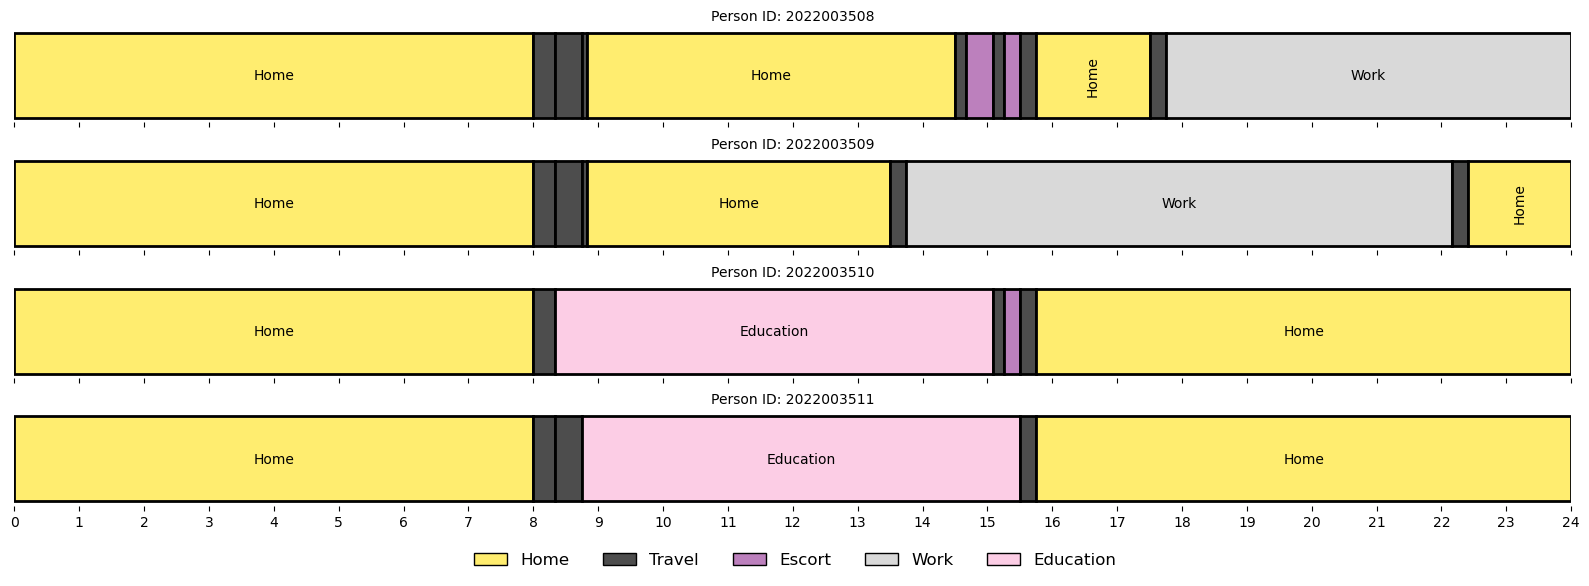

In [170]:
# I want to see what's inside ppoulation
#household_i = population.households[2022001569]
household_i = population.households[2022001554]

household_i.print()
household_i.plot()